# Ch 2. Programming Probabilistically

In this chapter, we will cover the following topics:

- Probabilistic programming
- PyMC3 primer
- The coin-flipping problem revisited
- Summarizing the posterior
- The Gaussian and student's t models
- Comparing groups and the effect size
- Hierarchical models and shrinkage

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from scipy import stats

%config InlineBackend.figure_format = 'retina'

## Probabilistic programming

> Bayesian statistics is conceptually very simple; we have the knows and the unknowns; we use Bayes' theorem to condition the latter on the former. If we are lucky, this process will reduce the uncertainty about the unknowns. Generally, we refer to the knowns as data and treat it like a constant, and the unknowns as parameters and treat them as probability distributions.

## PyMC3 primer

- a library for probabilistic programming
- uses NumPy and Theano
    - Theano is a deep learning algorithm that supplies the automatic differentiation required for sampling by PyMC3
    - Theano also compiles the code to C for faster execution
- Theano is no longer developed, but the PyMC devs are currently maintaining it
    - the next version of PyMC will use a different backend

### Flipping coins the PyMC3 way

- make synthetic coin flipping data, but we know the real $\theta$ value

In [2]:
np.random.seed(123)
trials = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

### Model specification

- need to specify the likelihood function and prior probability distribution
    - likelihood: binomial distribution with $n=1$ and $p=\theta$
    - prior: beta distribution with $\alpha=1$ and $\beta=1$
        - this beta distribution is equivalent to a uniform distirbution from $[0,1]$

$$
\theta \sim \text{Beta}(\alpha, \beta) \\
y \sim \text{Bern}(p=\theta)
$$

- this model using PyMC3:

In [3]:
with pm.Model() as our_first_model:
    θ = pm.Beta("θ", alpha=1.0, beta=1.0)
    y = pm.Bernoulli("y", p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


### Pushing the inference button

- the last line of the model specification above is "pressing the inference button"
    - asks for 1,000 samples from the posterior distribution

## Summarizing the posterior

- use `plot_trace()` to see the distribution of sampled values for $\theta$ and the MCMC chains

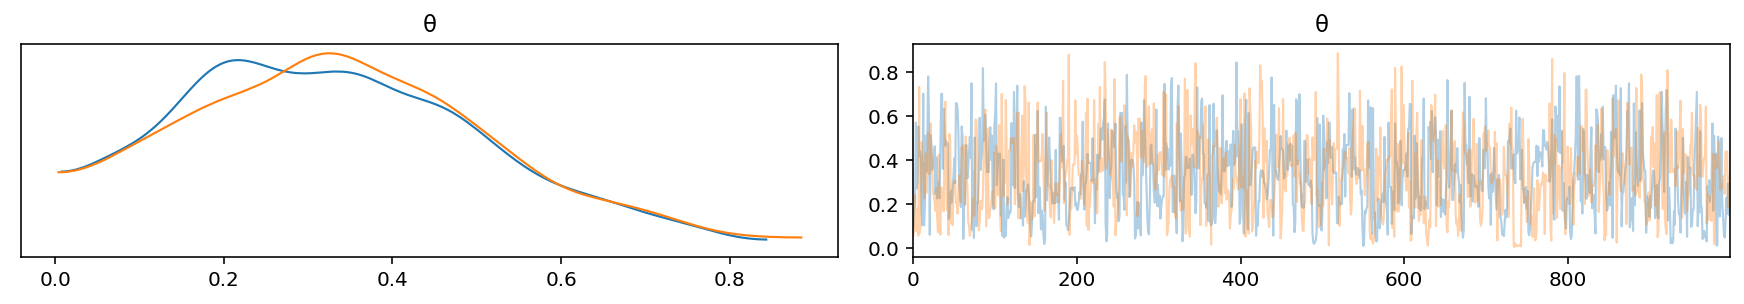

In [4]:
az_trace = az.from_pymc3(trace=trace, model=our_first_model)
p = az.plot_trace(az_trace)

- use `summary()` to get a Pandas data frame describing the posterior

In [5]:
az.summary(az_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.336,0.177,0.027,0.663,0.006,0.004,806.0,806.0,744.0,800.0,1.0


- use `plot_posterior()` to visualize the posterior distribution of $\theta$

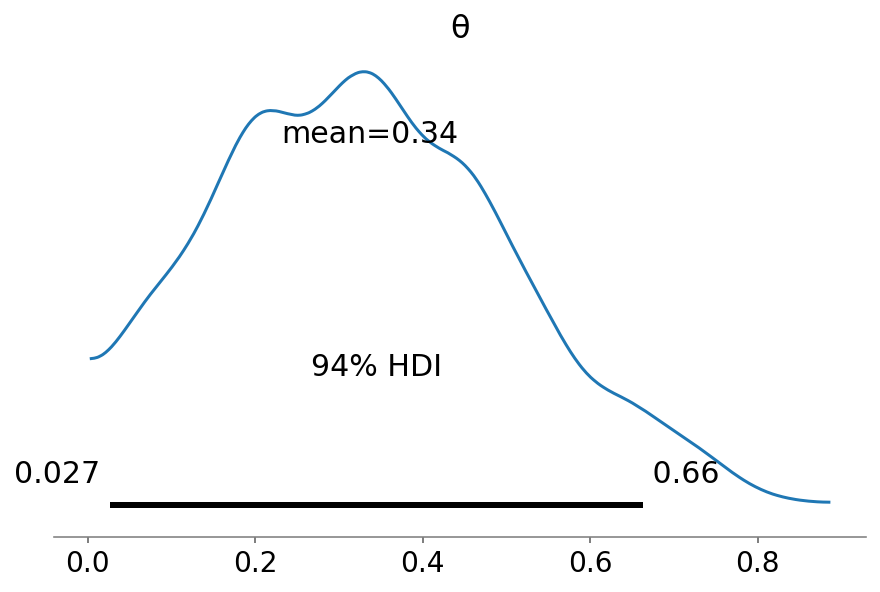

In [6]:
p = az.plot_posterior(az_trace)

### Posterior-based descisions

- sometimes need to go further than just descirbing the posterior and actually make a decision

#### ROPE

- **Region Of Practical Equivalence**: a region of the posteior distibution that would be effectively equivalent to a specific value
    - example: a fair coin has $\theta=0.5$ then the ROPE could be $[0.45, 0.55]$

> A ROPE is an arbitrary interval we choose based on background knowledge. Any value inside this interval is assumed to be of practical equivalence.

- comapre the ROPE against the **Highest-Posterior Density (HPD)**
- 3 possible scenarios:
    - the ROPE and HPD do not overalp: the coin is not fair
    - the ROPE contains the entire HPD: the coin is fair
    - the ROPE partially overlaps the HPD: the coin may be fair or unfair
- can include a range for the ROPE in `plot_posterior()`

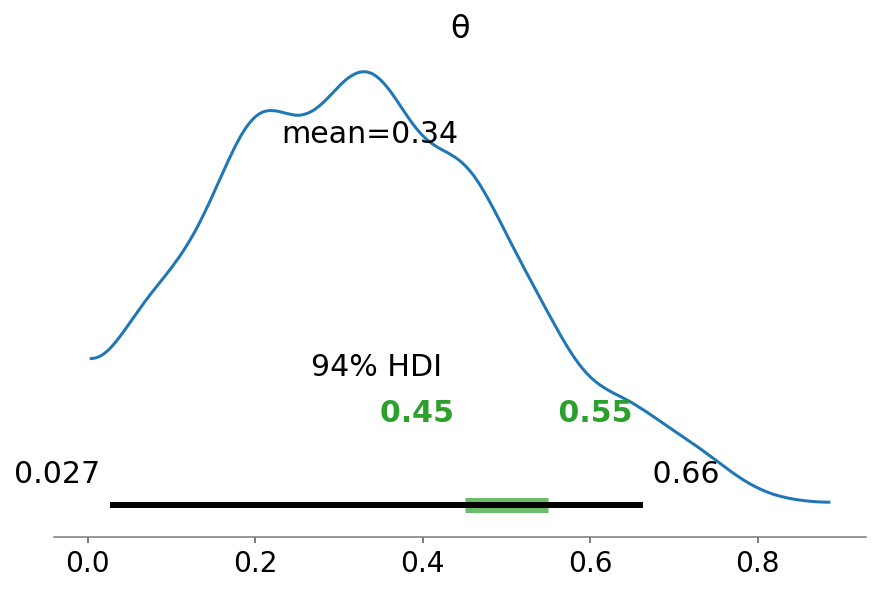

In [7]:
p = az.plot_posterior(az_trace, rope=[0.45, 0.55])

- can also compare the posterior against a reference value
    - example: 0.5 for a fair coin

<AxesSubplot:title={'center':'θ'}>

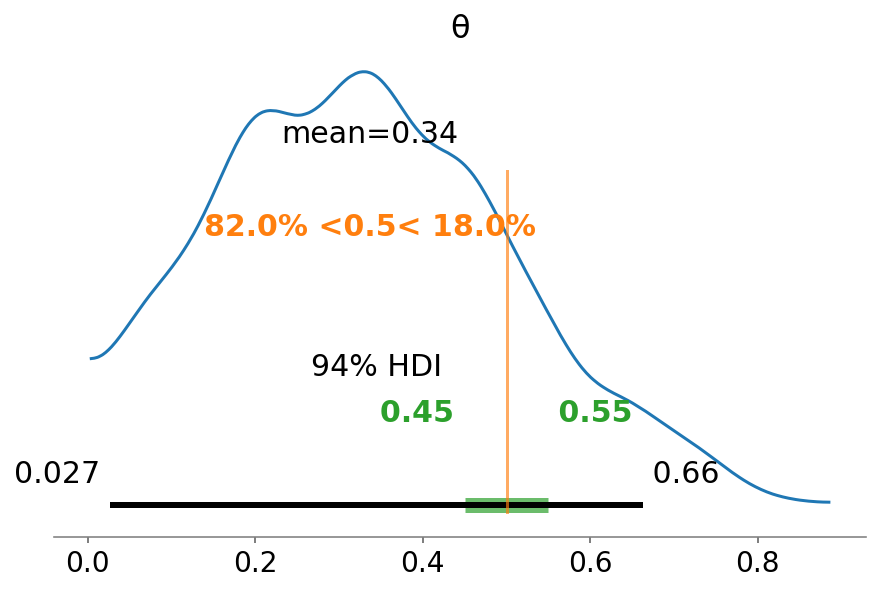

In [8]:
az.plot_posterior(az_trace, rope=[0.45, 0.55], ref_val=0.5)

#### Loss functions

- loss functoin is a mathematical formalization of a cost/benefit trade-off
    - indicate how different the true and estimated values of a prameter are
- common loss functions:
    - *quadratic*: $(\theta - \hat{\theta})^2$
    - *absolute*: $| \theta - \hat{\theta} |$
    - *0-1*: $I(\theta \neq \hat{\theta})$
- since we don't know the true parameter value, instead try to find the value of $\hat{\theta}$ that minimizes the **expected loss function**
    - expected loss function is the loss function averages over the entire posterior distribution
- example below shows the absolute loss `lossf_a` and quadratic loss `lossf_b`

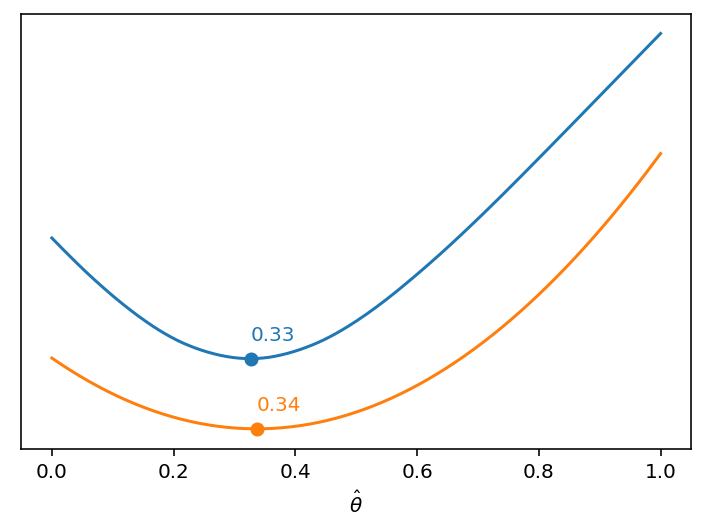

In [9]:
grid = np.linspace(0, 1, 200)
theta_pos = trace["θ"]
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos) ** 2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ["C0", "C1"]):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], "o", color=c)
    plt.annotate("{:.2f}".format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r"$\hat{\theta}$")

## Gaussians all the way down



### Gaussian inferences

- the data need not be a Gaussian, just that a Gaussian is a *reasonable approximation* of the data
    - some example data of NMR chemical shifts

In [10]:
data = np.loadtxt("data/chemical_shifts.csv")
data

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16])

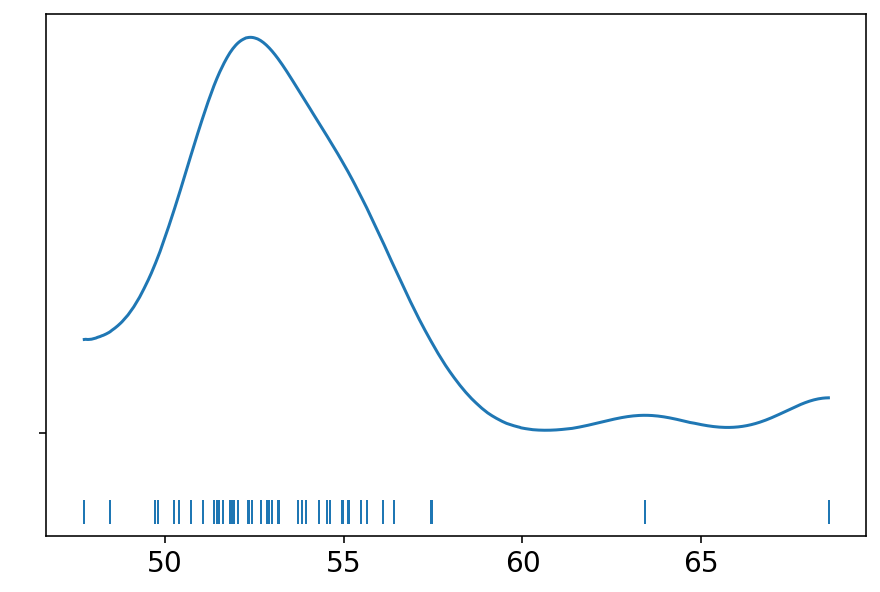

In [11]:
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.show()

- we do not know the mean nor standard deviation, so set priors for them
- example model

$$
\mu \sim U(l,h) \\
\sigma \sim | \mathcal{N}(0, \sigma_{\sigma}) | \\
y \sim \mathcal{N}(\mu, \sigma)
$$

- this model in code

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, µ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


array([[<AxesSubplot:title={'center':'µ'}>,
        <AxesSubplot:title={'center':'µ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

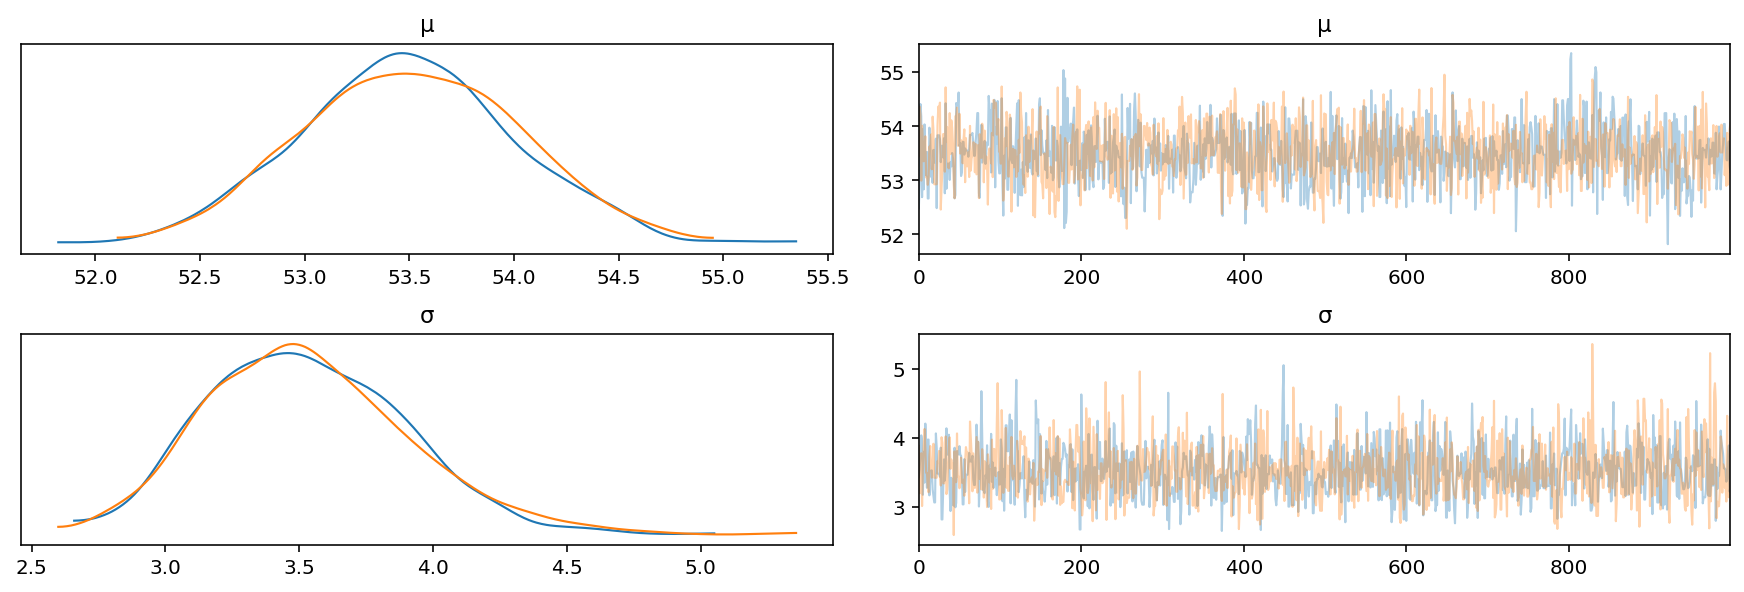

In [12]:
with pm.Model() as model_g:
    µ = pm.Uniform("µ", lower=40, upper=70)
    σ = pm.HalfNormal("σ", sd=10)
    y = pm.Normal("y", mu=µ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

az_trace_g = az.from_pymc3(trace=trace_g, model=model_g)
az.plot_trace(az_trace_g)

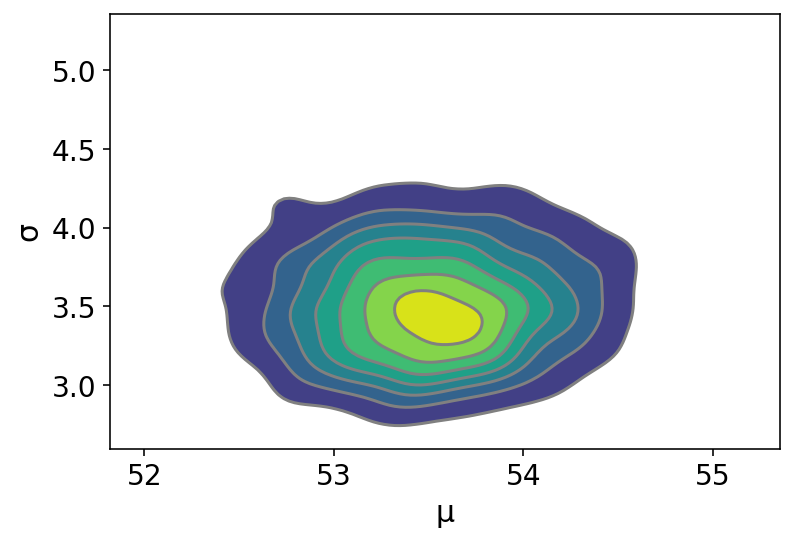

In [13]:
az.plot_pair(az_trace_g, kind="kde", fill_last=False)
plt.show()

- can get access to values in a `trace` object by indexing with the parameter name
    - returns a NumPy array

In [14]:
len(trace_g["σ"])

2000

In [15]:
az.summary(az_trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
µ,53.503,0.512,52.608,54.518,0.013,0.009,1490.0,1486.0,1505.0,1241.0,1.0
σ,3.533,0.377,2.874,4.258,0.009,0.006,1731.0,1715.0,1741.0,1297.0,1.0


- use the `sample_posterior_predictive()` function to do **posterior predictive checks**

In [16]:
y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


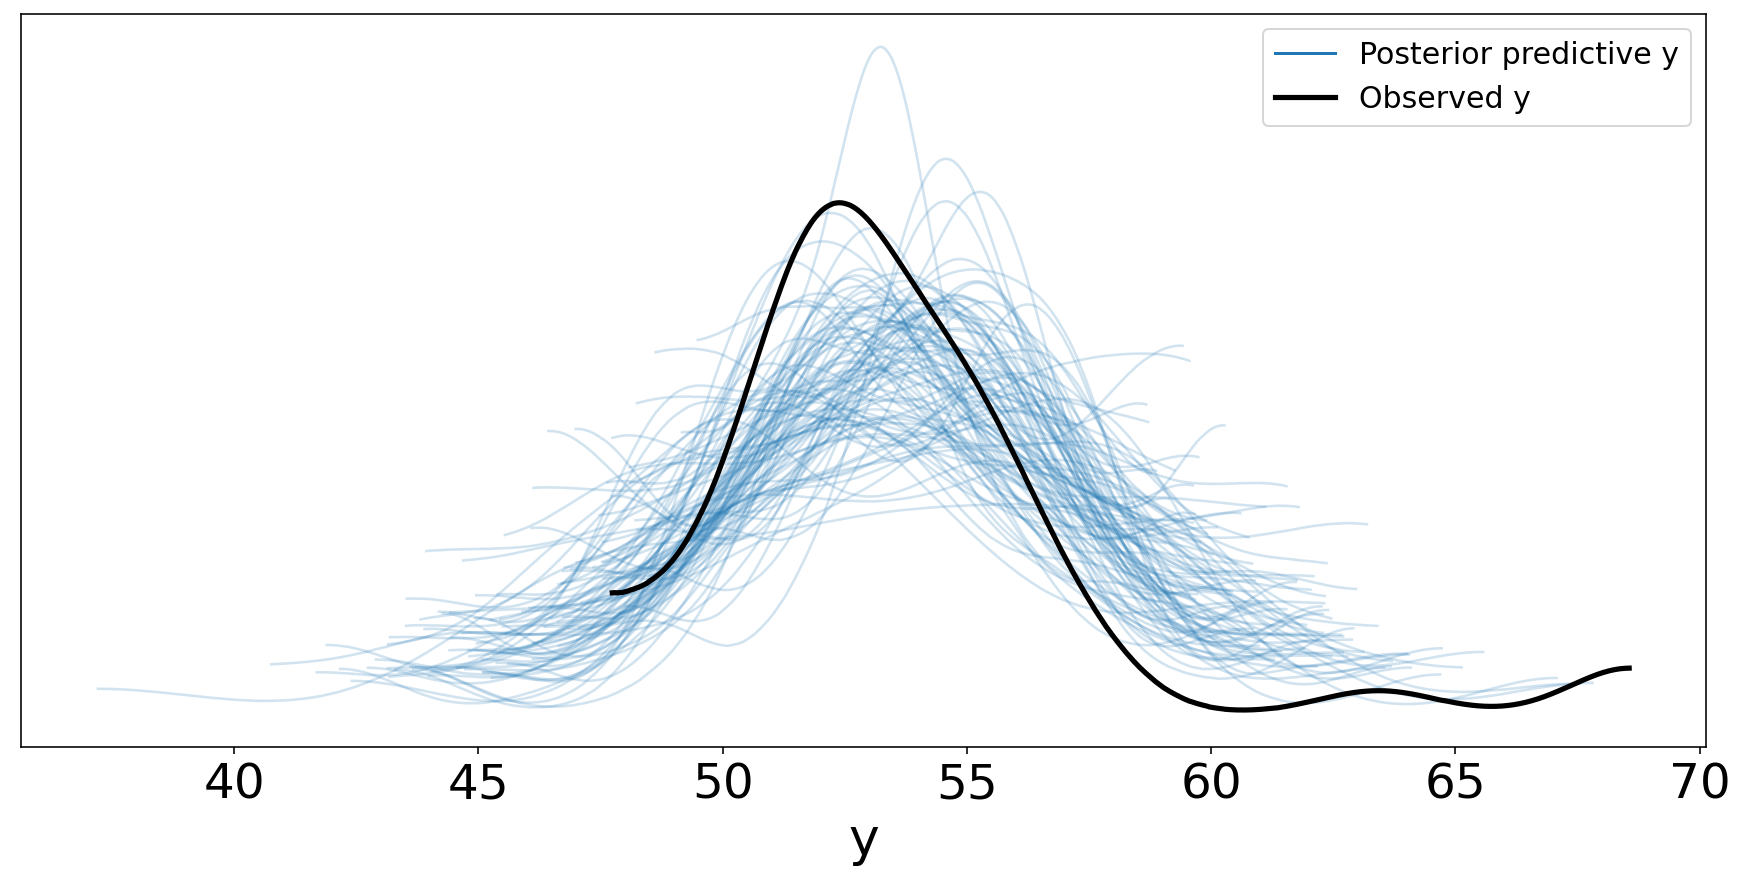

In [17]:
data_ppc = az.from_pymc3(trace=trace_g, model=model_g, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
plt.legend(fontsize=15)
plt.show()

- from the plot, see that the mean is shifted to the right and variance is quite high
    - see a better model for this data in the next section

### Robust inferences

#### Student's t-distribution

- instead of removing outliers, replace the Gaussian with a Student's t-distribution
    - has 3 parameters: mean, scale, and degrees of freedom ($\nu \in [0, \infty]$)
    - call the $\nu$ the *normality parameter* because it controls how "normal-like" the distribution is
        - $\nu = 1$: heavy tails (Cauchy or Lorentz distributions)
        - as $\nu$ gets larger, it appraoches a Gaussian
    - for $\nu \leq 1$: no defined mean
    - for $\nu \leq 2$: no defined variance (or std. dev.)

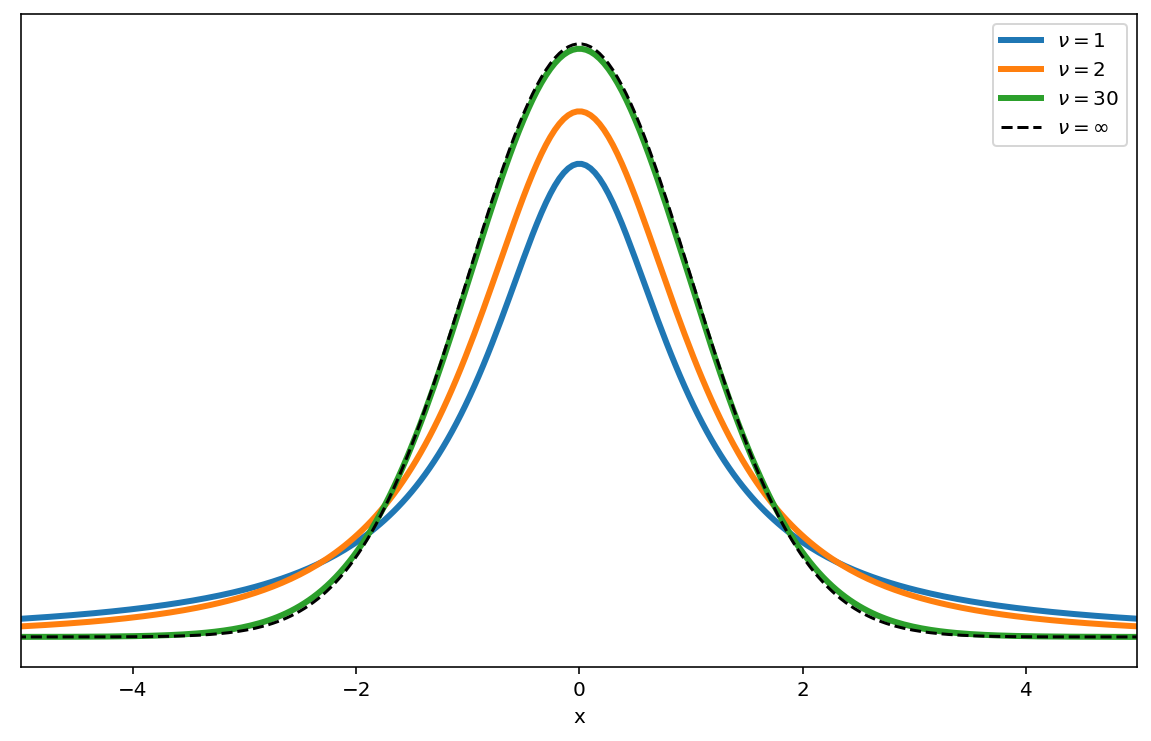

In [18]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for dof in [1, 2, 30]:
    distrib = stats.t(dof)
    x_pdf = distrib.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr"$\nu = {dof}$", lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, "k--", label=r"$\nu = \infty$")
plt.xlabel("x")
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.show()

- rewrite the previous model with Student's t-distribution instead of a Gaussian
    - we will provide $\nu$ with an unimformative exponential prior to indicate we think it will be mostly normal

$$
\mu \sim \mathcal{U}(l,h) \\
\sigma \sim | \mathcal{N}(0, \sigma_{\sigma}) |  \\
\nu \sim Exp(\lambda) \\
y \sim \mathcal{T}(\mu, \sigma, \nu)
$$

In [19]:
with pm.Model() as model_t:
    µ = pm.Uniform("µ", 40, 75)
    σ = pm.HalfNormal("σ", sd=10)
    ν = pm.Exponential("ν", 1 / 30)  # d.o.f. is parameterized as the inverse mean
    y = pm.StudentT("y", mu=µ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, µ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


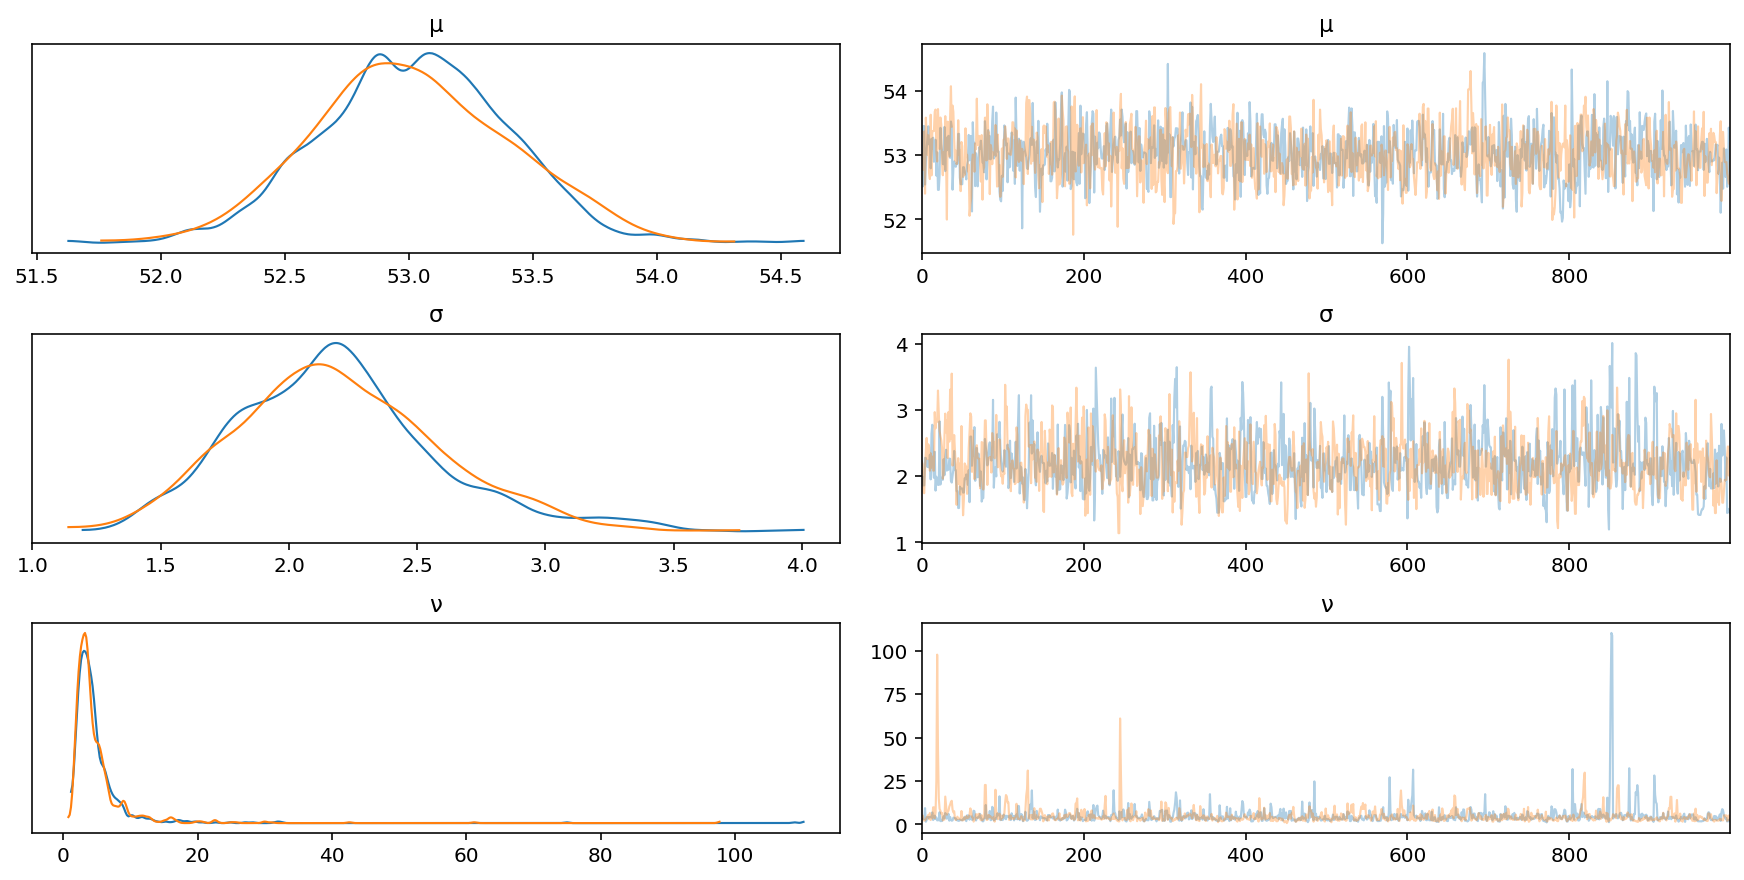

In [20]:
az_trace_t = az.from_pymc3(trace=trace_t, model=model_t)
az.plot_trace(az_trace_t)
plt.show()

In [21]:
az.summary(az_trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
µ,53.018,0.388,52.317,53.736,0.012,0.008,1124.0,1124.0,1124.0,1257.0,1.0
σ,2.199,0.415,1.426,2.950,0.014,0.010,844.0,844.0,838.0,823.0,1.0
ν,4.854,5.626,1.386,10.063,0.208,0.147,729.0,729.0,854.0,904.0,1.0


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


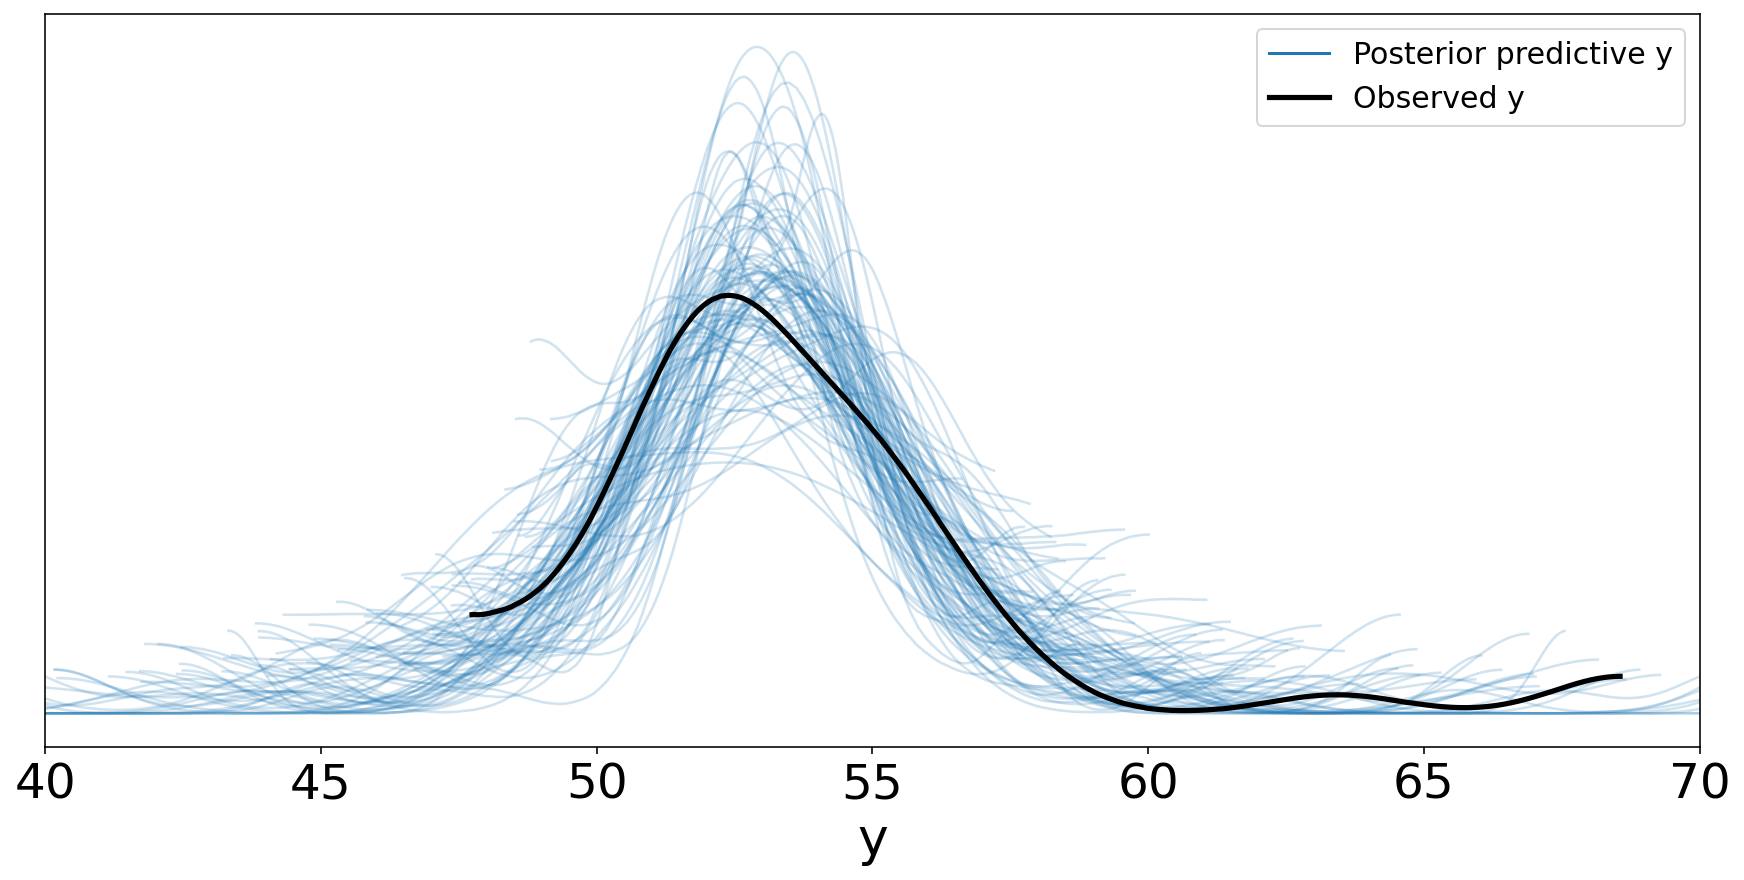

In [22]:
y_ppc_t = pm.sample_posterior_predictive(trace_t, 100, model_t, random_seed=123)
y_pred_t = az.from_pymc3(trace=trace_t, model=model_t, posterior_predictive=y_ppc_t)
ax = az.plot_ppc(y_pred_t, figsize=(12, 6), mean=False)
plt.legend(fontsize=15)
plt.xlim(40, 70)
plt.show()

## Groups comparison

- this author emphasizes useing effect size and uncertainty over just presenting a p-value (or some other yes/no indicator)
- specifically, 3 tools:
    1. a posterior plot with a reference value
    2. the Cohen's d
    3. the probability of superiority

### Cohen's d

formula: $\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 + \sigma_1^2}{2}}}$

- the difference in means with respect to the pooled standard deviation of both groups

### Probability of superiority

- the probability that a data point taken at random from one group has a larger value than one taken at random from the other group
- if the data is normally distributed, can compute using Cohen's d ($\delta$) and the cumulative normal distribution $\Phi$

$ps = \Phi(\frac{\delta}{\sqrt{2}})$

- it can also be computed if we have direct samples from the posterior (such as from MCMC)

### The tips dataset

- example: study the effect of the day of the week on the amount of tips at a restaurant

In [23]:
tips = pd.read_csv("data/tips.csv")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


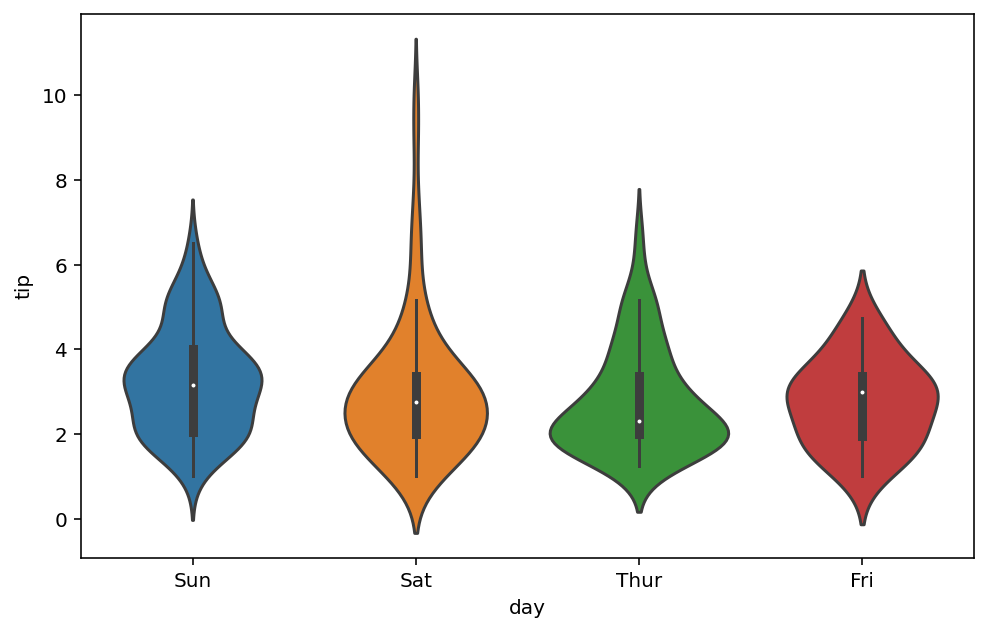

In [24]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="day", y="tip", data=tips)
plt.show()

- make some variables to make handling the data easier

In [25]:
tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=["Thur", "Fri", "Sat", "Sun"]).codes
groups = len(np.unique(idx))

- same model as `model_g` except now $\mu$ and $\sigma$ are vectors, one value per day of the week

In [26]:
with pm.Model() as comparing_groups:
    µ = pm.Normal("µ", mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal("σ", sd=10, shape=groups)

    y = pm.Normal("y", mu=µ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, µ]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds.


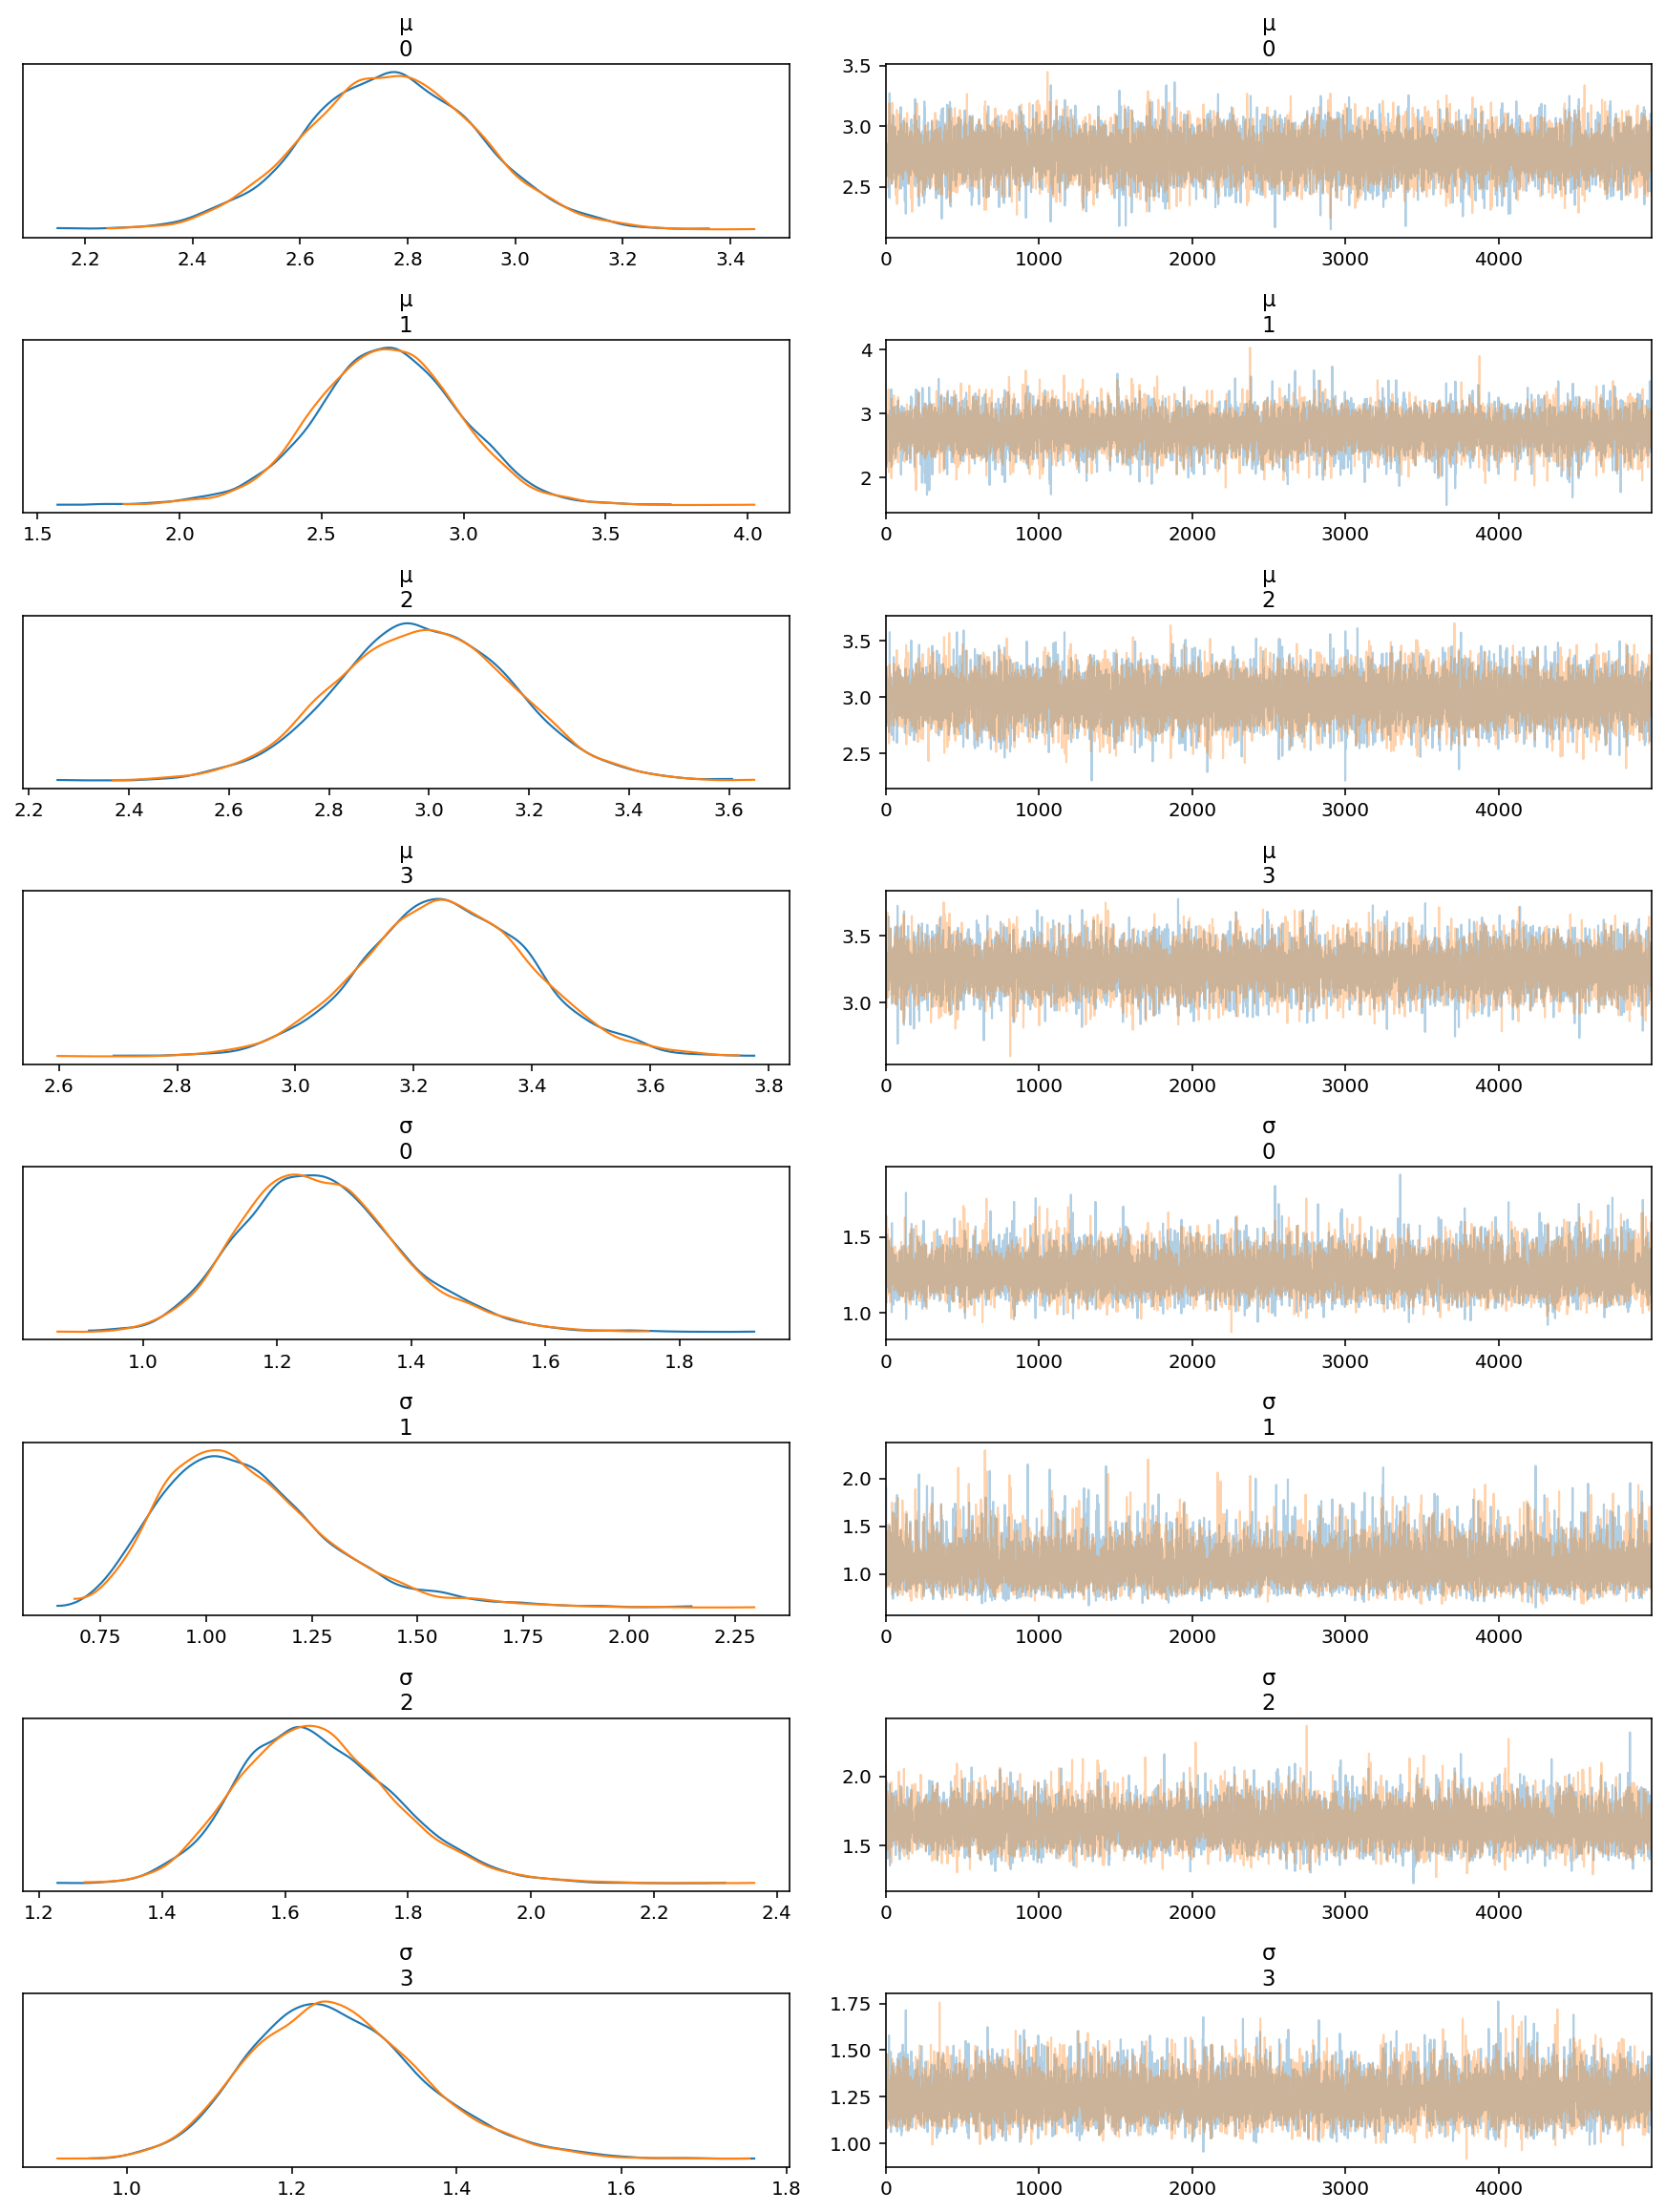

In [27]:
az_trace_cg = az.from_pymc3(trace=trace_cg, model=comparing_groups)
az.plot_trace(az_trace_cg)
plt.show()

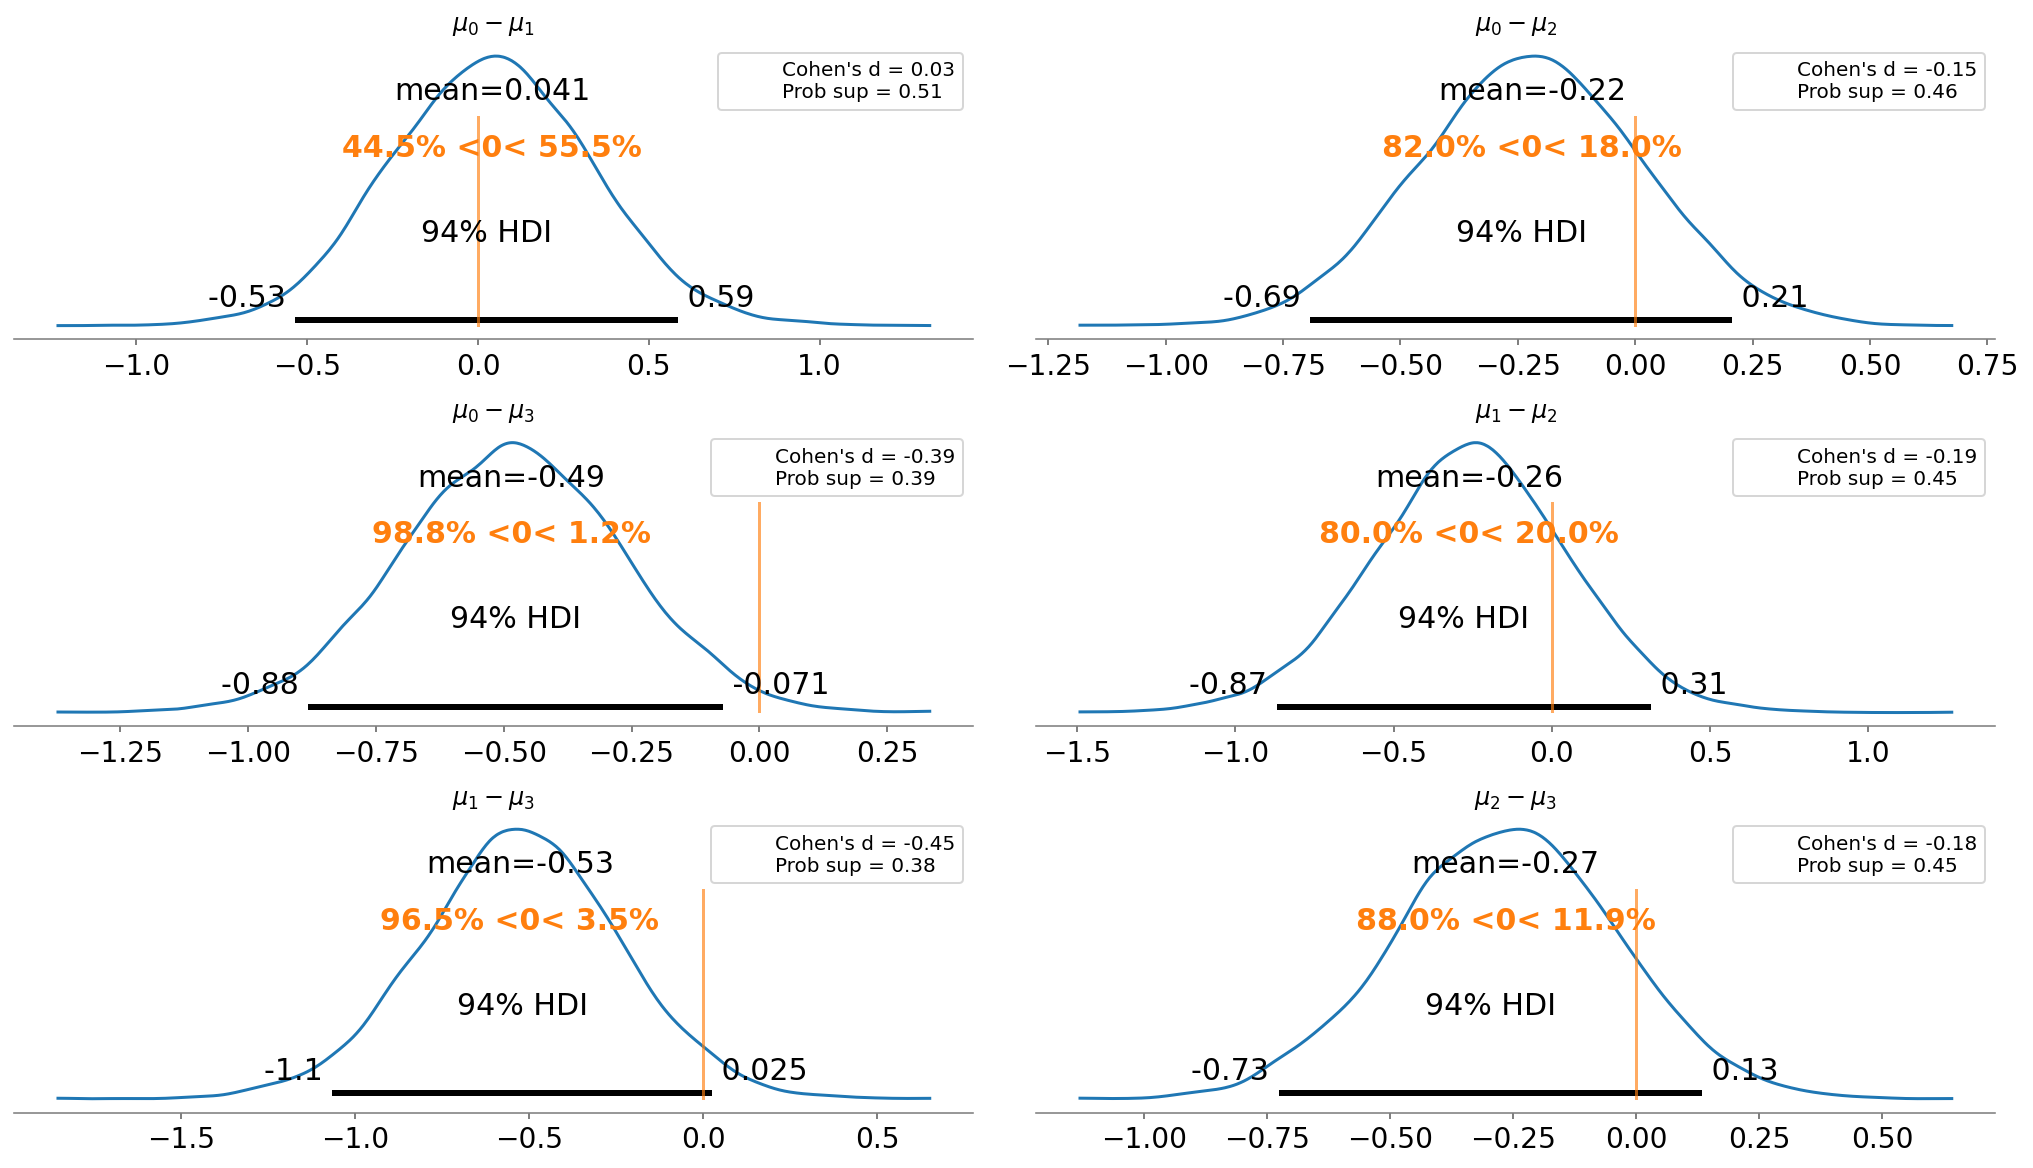

In [28]:
dist = stats.norm()

fig, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i + 1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg["µ"][:, i] - trace_cg["µ"][:, j]
    d_cohen = (
        means_diff / np.sqrt((trace_cg["σ"][:, i] ** 2 + trace_cg["σ"][:, j] ** 2) / 2)
    ).mean()
    ps = dist.cdf(d_cohen / (2 ** 0.5))

    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(fr"$\mu_{i}-\mu_{j}$")
    ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

## Hierarchical models

- instead of fixing parameters of the priors to some constant, estimate the priors over all of the data
    - called *hyper-priors* with *hyperparameters*
- example of mock water quality measurements collected from 3 regions within a city
    - values of lead above healthy standards are marked with 0 and those below are makred with 1

In [29]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i] - G_samples[i]]))

print(group_idx[:20])
print(data[:20])
print(len(data))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
90


- model is a the same as for a coin flip except:
    - defined 2 hhyper-priors that will influence the beta prior
    - instead of putting hyper-priors on the parameters $\alpha$ and $\beta$, indirectly define them with $\mu$ (mean of the beta distribution)and $\kappa$ (the precision of the beta distribution; effectively the inverse of std. dev.)

$$
\mu \sim \text{Beta}(\alpha_{\mu}, \beta_{\mu}) \\
\kappa \sim | \mathcal{N}(0, \sigma_\kappa) | \\
\alpha = \mu \times \kappa \\
\beta = (1 - \mu) \times \kappa \\
\theta_i \sim \text{Beta}(\alpha_i, \beta_i) \\
y_i \sim \text{Bernoulli}(\theta_i)
$$

In [30]:
with pm.Model() as model_h:
    µ = pm.Beta("µ", 1.0, 1.0)
    κ = pm.HalfNormal("κ", 10)

    θ = pm.Beta("θ", alpha=µ * κ, beta=(1.0 - µ) * κ, shape=len(N_samples))
    y = pm.Bernoulli("y", p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, µ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.


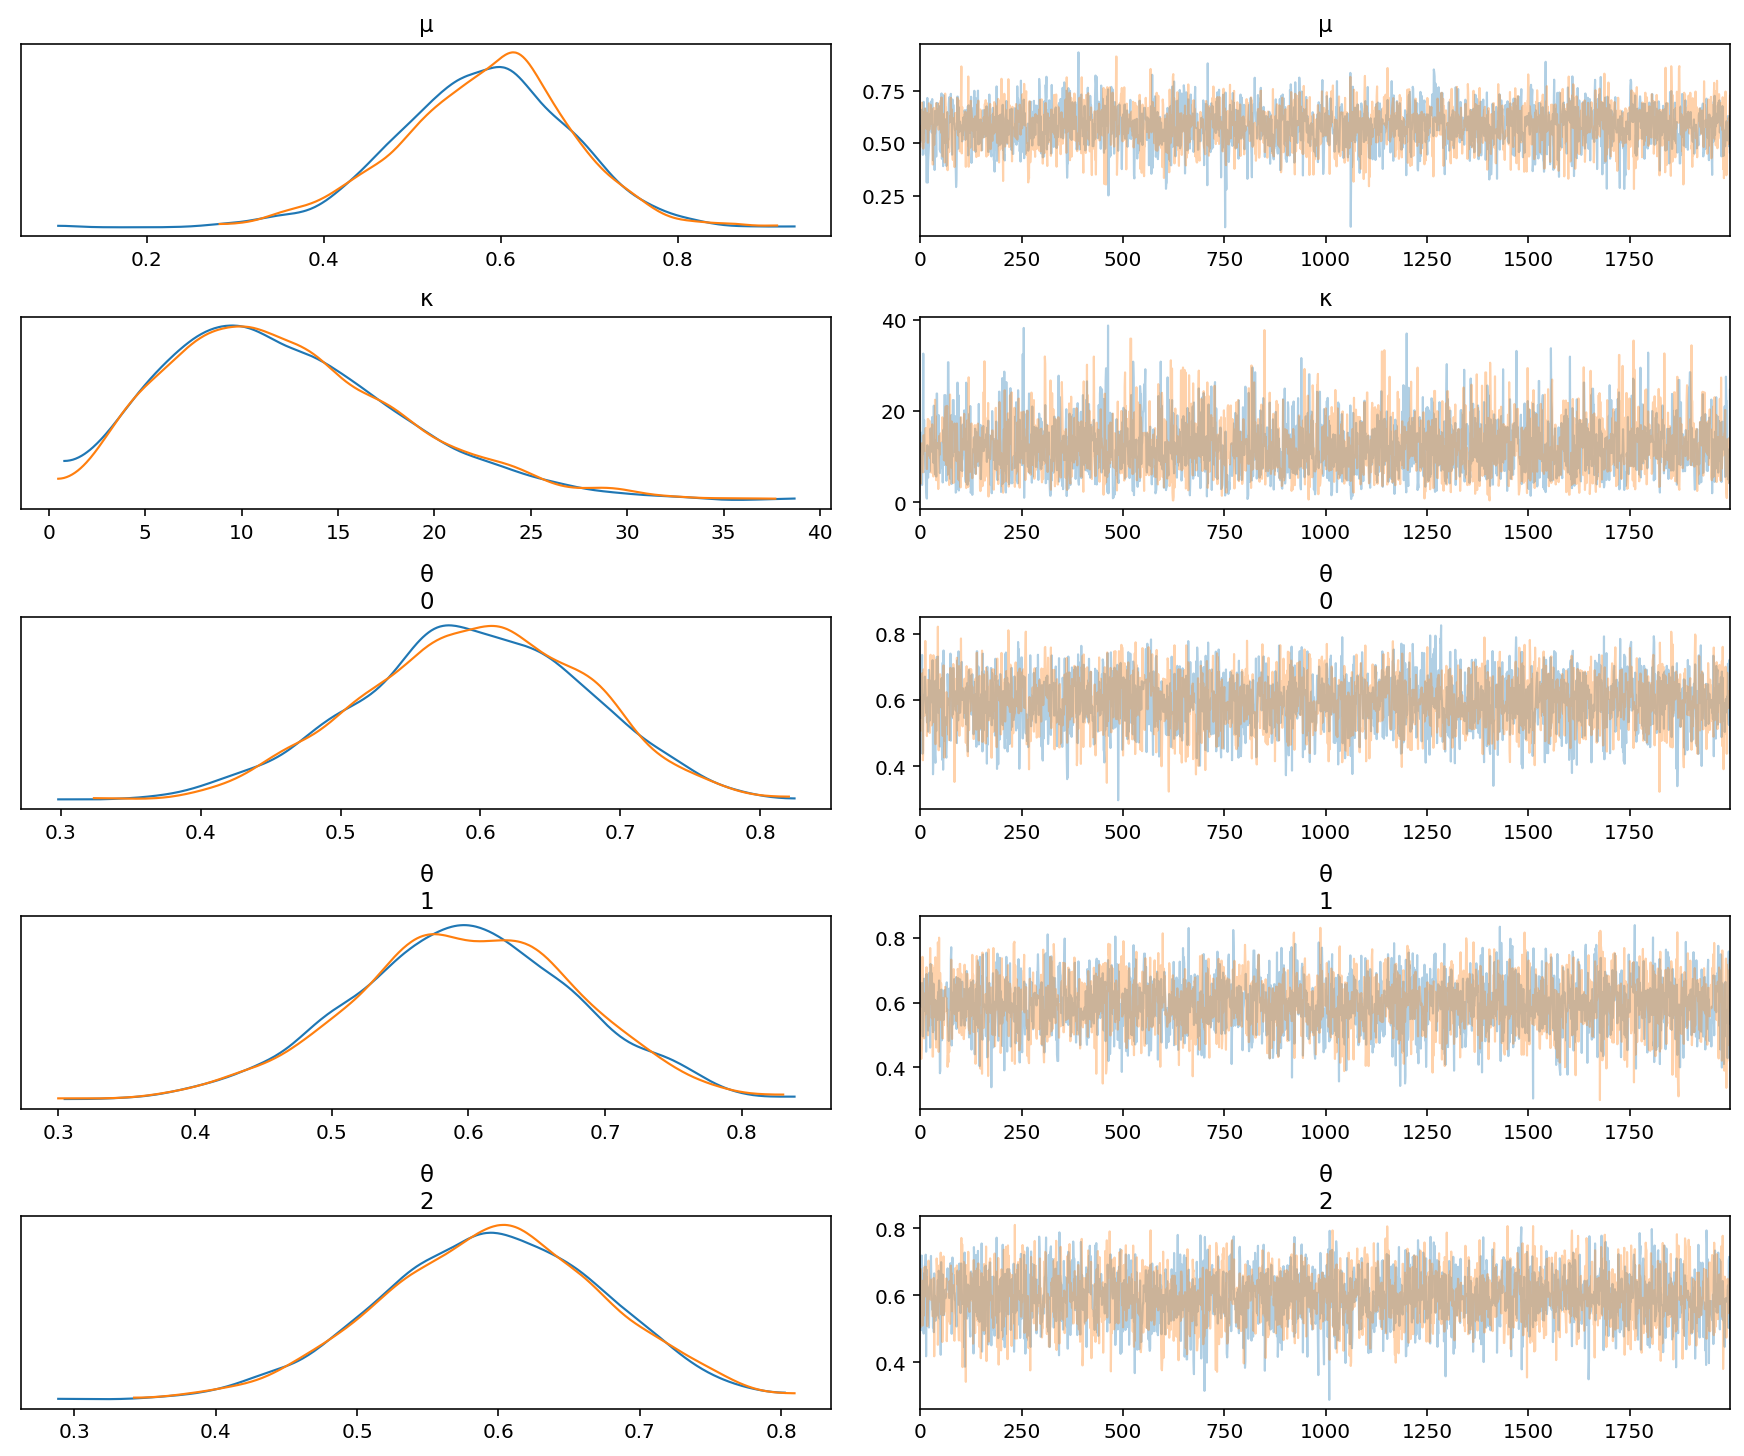

In [31]:
az_trace_h = az.from_pymc3(trace=trace_h, model=model_h)
az.plot_trace(az_trace_h)
plt.show()

### Shrinkage

- when the parameters share information through the hyper-prior, they *shrink* towards the value instead of remaining completely separate
    - paritally pooling the data
- shrinkinage contributes to more stable inferences
- can use a more informative prior on the hyper-prior to increase the amount of shrinkage

### One more example

- an example of a hierarchical model with protein NMR data
    - want to compare the differences between theoretical (`theo`) and experimental (`exp`) chemical shift values

In [32]:
cs_data = pd.read_csv("data/chemical_shifts_theo_exp.csv")
cs_data.head()

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64


In [33]:
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data["aa"]).codes
groups = len(np.unique(idx))
print(f"There are {groups} different amino acids in the data.")

There are 19 different amino acids in the data.


- for comparison, we will build both a non-hierarchical model and a hierarchical model

In [34]:
with pm.Model() as cs_nh:
    µ = pm.Normal("µ", mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal("σ", sd=10, shape=groups)

    y = pm.Normal("y", mu=µ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, µ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


In [35]:
with pm.Model() as cs_h:
    # hyper-priors on varying µ
    µ_µ = pm.Normal("µ_µ", mu=0, sd=10)
    σ_µ = pm.HalfNormal("σ_µ", 10)

    # priors
    µ = pm.Normal("µ", mu=µ_µ, sd=σ_µ, shape=groups)
    σ = pm.HalfNormal("σ", sd=10, shape=groups)

    y = pm.Normal("y", mu=µ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, µ, σ_µ, µ_µ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


- compare the models using `plot_forest()`

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


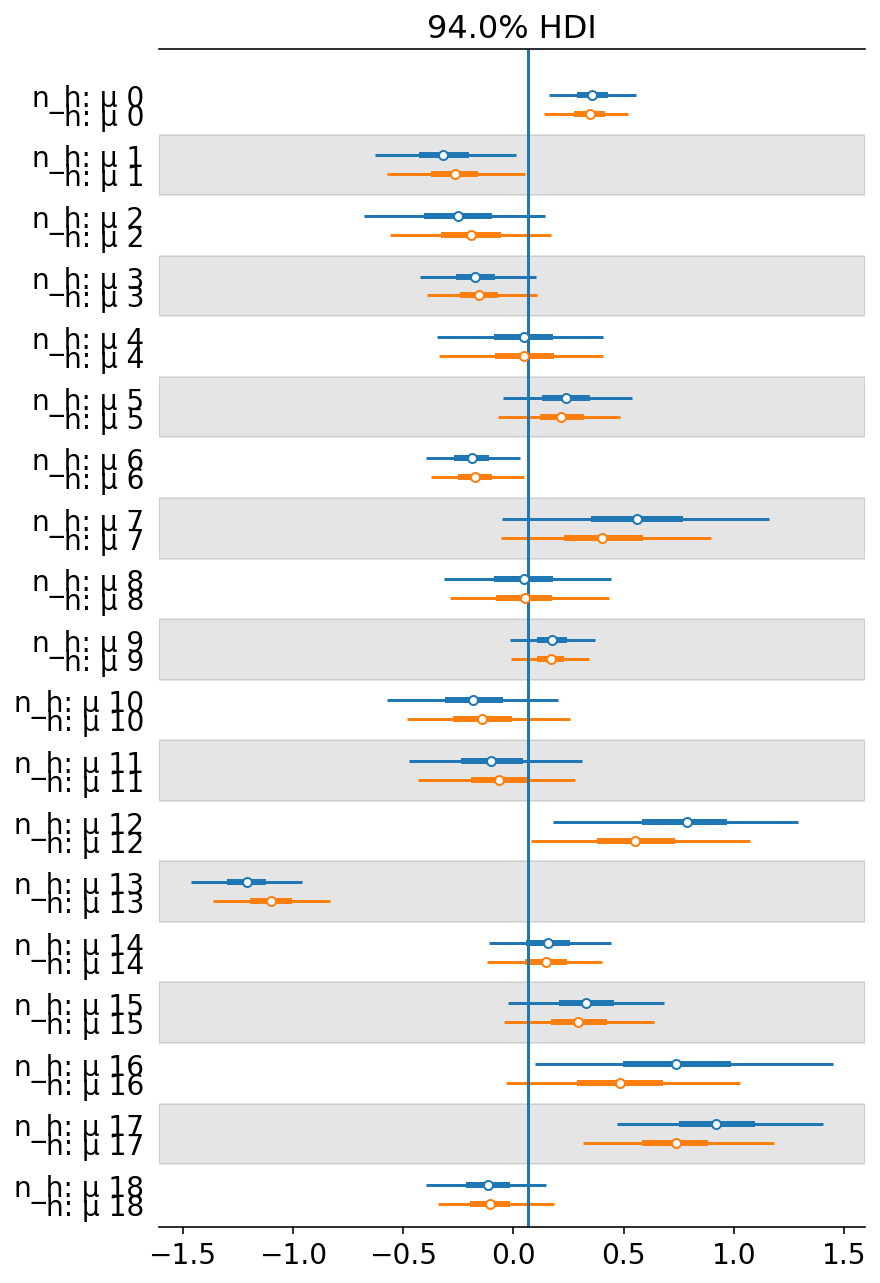

In [36]:
axes = az.plot_forest(
    [az.from_pymc3(trace_cs_nh), az.from_pymc3(trace_cs_h)],
    model_names=["n_h", "h"],
    var_names="µ",
    combined=True,
    colors="cycle",
)

y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h["µ_µ"].mean(), *y_lims)

plt.show()

---

In [37]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-04

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: master

matplotlib: 3.3.3
pandas    : 1.2.0
seaborn   : 0.11.1
arviz     : 0.10.0
scipy     : 1.6.0
numpy     : 1.19.4
pymc3     : 3.9.3

